In [12]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import open3d as o3d 
from mpl_toolkits import mplot3d

ply_header = '''ply
format ascii 1.0
element vertex %(vert_num)d
property float x
property float y
property float z
property uchar red
property uchar green
property uchar blue
end_header
'''

img = cv.imread('images/baggage_claim.jpg')
gray= cv.cvtColor(img,cv.COLOR_BGR2GRAY)


In [ ]:
sift = cv.xfeatures2d.SIFT_create()


In [ ]:
kp = sift.detect(gray,None)
img=cv.drawKeypoints(gray,kp,img)
plt.imshow(img);
plt.show()

In [ ]:
def write_ply(fn, verts, colors):
    verts = verts.reshape(-1, 3)
    colors = colors.reshape(-1, 3)
    verts = np.hstack([verts, colors])
    with open(fn, 'wb') as f:
        f.write((ply_header % dict(vert_num=len(verts))).encode('utf-8'))
        np.savetxt(f, verts, fmt='%f %f %f %d %d %d ')

In [ ]:


# disparity range is tuned for 'aloe' image pair
window_size = 3
min_disp = 16
num_disp = 112-min_disp
# stereo = cv.StereoSGBM_create(minDisparity = min_disp,
#     numDisparities = num_disp,
#     blockSize = 16,
#     P1 = 8*3*window_size**2,
#     P2 = 32*3*window_size**2,
#     disp12MaxDiff = 1,
#     uniquenessRatio = 10,
#     speckleWindowSize = 100,
#     speckleRange = 32
# )



print('computing disparity...')
#disp = stereo.compute(imgL, imgR).astype(np.float32) / 16.0

print('generating 3d point cloud...',)
h, w = imgL.shape[:2]
f = 0.8*w                          # guess for focal length
Q = np.float32([[1, 0, 0, -0.5*w],
                [0,-1, 0,  0.5*h], # turn points 180 deg around x-axis,
                [0, 0, 0,     -f], # so that y-axis looks up
                [0, 0, 1,      0]])
points = cv.reprojectImageTo3D(disp, Q)
colors = cv.cvtColor(imgL, cv.COLOR_BGR2RGB)
mask = disp > disp.min()
out_points = points[mask]
out_colors = colors[mask]
out_fn = 'out.ply'
write_ply(out_fn, out_points, out_colors)
print('%s saved' % out_fn)

cv.imshow('left', imgL)
cv.imshow('disparity', (disp-min_disp)/num_disp)
cv.waitKey()

print('Done')


# if __name__ == '__main__':
#     print(__doc__)
#     main()
cv.destroyAllWindows()

In [13]:
imgL = cv.imread('images/leftStereo.jpg') # downscale images for faster processing
imgR = cv.imread('images/rightStereo.jpg')

In [15]:
stereo = cv.StereoBM_create(numDisparities=16, blockSize=15)
frame0_new = cv.cvtColor(imgL, cv.COLOR_BGR2GRAY)
frame1_new = cv.cvtColor(imgR, cv.COLOR_BGR2GRAY)

disp = stereo.compute(frame0_new,frame1_new)
h, w = imgL.shape[:2]
f = 0.8*w                          # guess for focal length


In [ ]:
real_X = np.zeros(disp.shape)
real_Y = np.zeros(disp.shape)
for x in range(len(disp[0])):
    for y in range(len(disp[1])):
        real_X[x,y] = x * disp[x,y] / f
        real_Y[x,y] = y * disp[x,y] / f

        
        

In [16]:
globalCoords = np.zeros([disp.shape[0] * disp.shape[1], 3])

for x in range(len(disp[0])):
    for y in range(len(disp[1])):
        globalCoords[x*y, 0] = x * disp[x,y] / f
        globalCoords[x*y, 1] = y * disp[x,y] / f
        globalCoords[x*y, 2] = disp[x,y]

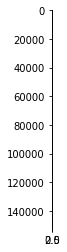

In [18]:
plt.imshow(globalCoords)